In [1]:
import pandas as pd
from scipy import stats

# Q1: ANOVA
I belong to a golf club in my neighborhood. I divide the year into three golf seasons: summer (June–September), winter (November–March), and shoulder (October, April, and May). I believe that I play my best golf during the summer (because I have more time and the course isn’t crowded) and shoulder (because the course isn’t crowded) seasons, and my worst golf is during the winter (because when all of the part-year residents show up, the course is crowded, play is slow, and I get frustrated). Data from the last year are shown in the following table.

In [2]:
group1 = [ 83, 85, 85, 87, 90, 88, 88, 84, 91, 90,]   # Summer]
group2 = [ 91, 87, 84, 87, 85, 86, 83,]               # Shoulder]
group3 = [ 94, 91, 87, 85, 87, 91, 92, 86,]            # Winter]


Test whether season has an effect on my golf scores. What is the test statistic?

In [3]:
# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(group1, group2, group3)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")


F-statistic: 2.1214422500338515
P-value: 0.14372166166670017


Do the data indicate that my opinion is correct? Use α = 0.05.

In [4]:
if p_value < 0.05:
    print("Reject the null hypothesis: There are significant differences between group means.")
else:
    print("Fail to reject the null hypothesis: No significant differences found.")

Fail to reject the null hypothesis: No significant differences found.


Analyze the residuals from this experiment and comment on model adequacy.

In [5]:
# Data
data = {
    "Season": ["Summer"] * 10 + ["Shoulder"] * 7 + ["Winter"] * 8,
    "Observations": [
        83, 85, 85, 87, 90, 88, 88, 84, 91, 90,   # Summer
        91, 87, 84, 87, 85, 86, 83,               # Shoulder
        94, 91, 87, 85, 87, 91, 92, 86            # Winter
    ]
}
df = pd.DataFrame(data)

In [6]:
group_mean = df.groupby("Season")["Observations"].transform("mean")
df["fitted"] = group_mean
df["error"] = df["Observations"] - group_mean

In [7]:
df.head()

,Season,Observations,fitted,error
0,Summer,83,87.1,-4.1
1,Summer,85,87.1,-2.1
2,Summer,85,87.1,-2.1
3,Summer,87,87.1,-0.1
4,Summer,90,87.1,2.9


### 1. Residuals vs. Fitted values

This checks if residuals are randomly scattered (no pattern = good).

Check: constant variance assumption and independence assumption

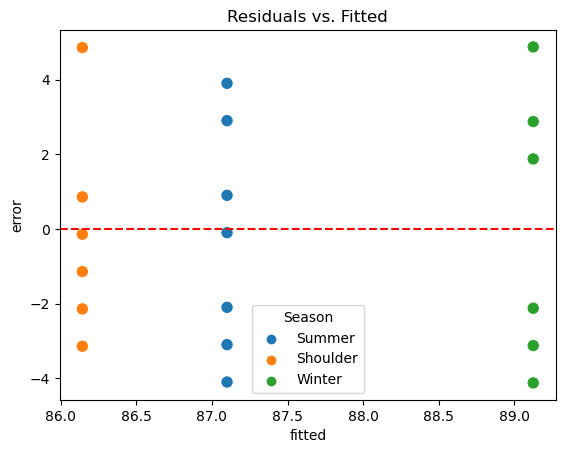

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats



# Plot
sns.scatterplot(x="fitted", y="error", hue="Season", data=df, s=80)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs. Fitted")
plt.show()


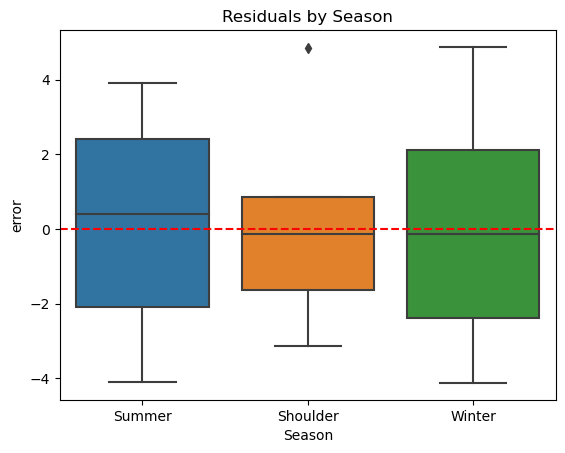

In [9]:
sns.boxplot(x="Season", y="error", data=df)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals by Season")
plt.show()


### 2. QQ Plot of residuals: Check normality of residuals assumption

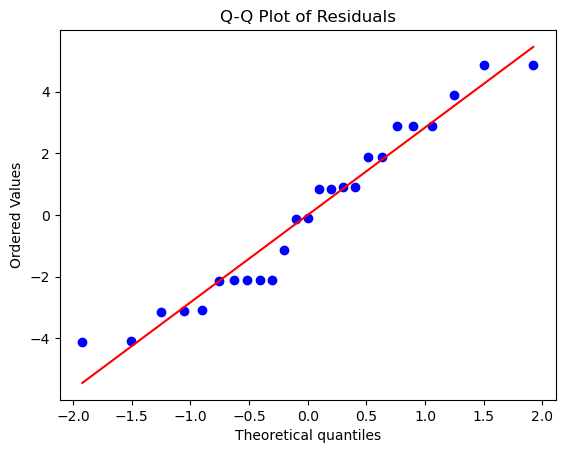

In [10]:
stats.probplot(df["error"], dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()


# Q2: Random Effect Model

A textile company weaves a fabric on a large number of looms. It would like the looms to be homogeneous so that it obtains a fabric of uniform strength. The process engineer suspects that, in addition to the usual variation in strength within samples of fabric from the same loom, there may also be significant variations in strength between looms. To investigate this, she selects four looms at random and makes four strength determinations on the fabric manufactured on each loom. This experiment is run in random order, and the data obtained are shown in Table 3.18.

In [11]:
df = pd.DataFrame({
    "Loom":     [1,1,1,1,   2,2,2,2,   3,3,3,3,   4,4,4,4],
    "Obs":      [1,2,3,4]*4,
    "Strength": [98,97,99,96,   91,90,93,92,   96,95,97,95,   95,96,99,98]
})

In [12]:
df.head()

,Loom,Obs,Strength
0,1,1,98
1,1,2,97
2,1,3,99
3,1,4,96
4,2,1,91


In [13]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from scipy.stats import chi2, f

In [14]:
def lrt_random_intercept(formula, data, group_col):
    """
    Likelihood ratio test for a single random intercept.
    H0: variance(component) = 0  (no random intercept)
    H1: variance(component) > 0  (random intercept present)

    Returns: dict with ll_full, ll_null, lrt, p_value
    """
    # FULL model: random intercept by group (fit with ML)
    m_full = mixedlm(formula, data=data, groups=data[group_col])
    fit_full = m_full.fit(reml=True)
    print("Random effect summary:")
    print(fit_full.summary())
    
    # Variance components and ICC
    between_var = float(fit_full.cov_re.iloc[0, 0])   # sigma_alpha^2 (between-loom variance)
    resid_var   = float(fit_full.scale)               # sigma^2 (within-loom/residual variance)
    icc = between_var / (between_var + resid_var)

    print("\nEstimated variance components:")
    print(f"  Between-loom variance (sigma_alpha^2): {between_var:.3f}")
    print(f"  Residual variance (sigma^2):           {resid_var:.3f}")
    print(f"  Intraclass correlation (ICC):          {icc:.3f}")
    print(f"  {100*icc:.1f}% of total variance comes from the treatment(loom).")

    # NULL model: intercept-only Gaussian model (no random effect), also ML
    fit_null = sm.OLS.from_formula(formula, data=data).fit()

    # Likelihood ratio
    lrt = 2 * (fit_full.llf - fit_null.llf)

    # Boundary-corrected p-value (0.5 * chi^2_1 upper tail)
    p_val = 0.5 * (1 - chi2.cdf(lrt, df=1))

    return {
        "ll_full": fit_full.llf,
        "ll_null": fit_null.llf,
        "lrt": lrt,
        "p_value": p_val,
        "fit_full": fit_full,  # return the fitted model too, handy to inspect
    }


res = lrt_random_intercept("Strength ~ 1", data=df, group_col="Loom")

Random effect summary:
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Strength
No. Observations: 16      Method:             REML    
No. Groups:       4       Scale:              1.8958  
Min. group size:  4       Log-Likelihood:     -31.5965
Max. group size:  4       Converged:          Yes     
Mean group size:  4.0                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept   95.437    1.363 70.015 0.000 92.766 98.109
Group Var    6.958    4.927                           


Estimated variance components:
  Between-loom variance (sigma_alpha^2): 6.958
  Residual variance (sigma^2):           1.896
  Intraclass correlation (ICC):          0.786
  78.6% of total variance comes from the treatment(loom).


In [15]:
print("LL(full):", res["ll_full"])
print("LL(null):", res["ll_null"])
print("LRT:", res["lrt"])
print("p-value (boundary-corrected):", res["p_value"])

LL(full): -31.596516242736673
LL(null): -38.265832191923955
LRT: 13.338631898374565
p-value (boundary-corrected): 0.00012999698049870334


In [16]:
# If you also want the classical ANOVA F-test (balanced one-way designs):

loom_groups = df.groupby("Loom")["Strength"].apply(list)
f_statistic, p_value = stats.f_oneway(*loom_groups)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

F-statistic: 15.681318681318682
P-value: 0.00018779198099318047


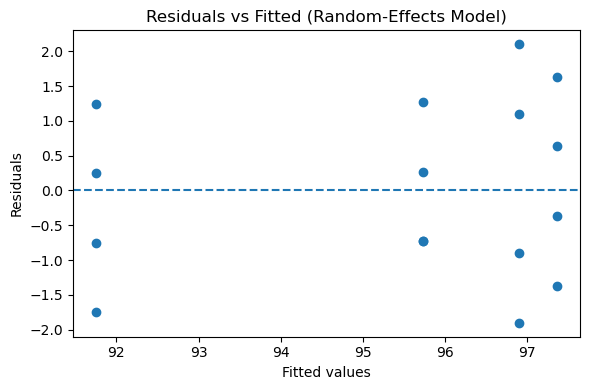

In [17]:
# 4) Simple diagnostic: residuals vs fitted
# -----------------------------
df["Fitted"] = res["fit_full"].fittedvalues
df["Residual"] = df["Strength"] - df["Fitted"]

plt.figure(figsize=(6,4))
plt.scatter(df["Fitted"], df["Residual"])
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Random-Effects Model)")
plt.tight_layout()
plt.show()